In [ ]:
!git clone https://huggingface.co/h94/IP-Adapter

In [ ]:
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

In [10]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "/content/IP-Adapter/models/image_encoder"
ip_ckpt = "/content/IP-Adapter/models/ip-adapter_sd15.bin"
device = "cuda"

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [ ]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

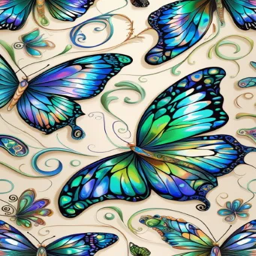

In [7]:
# read image prompt
from diffusers.utils import load_image
image = load_image("https://designcompetition.explorug.online/images/Motif%20based/50.webp")
image.resize((256, 256))

In [11]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

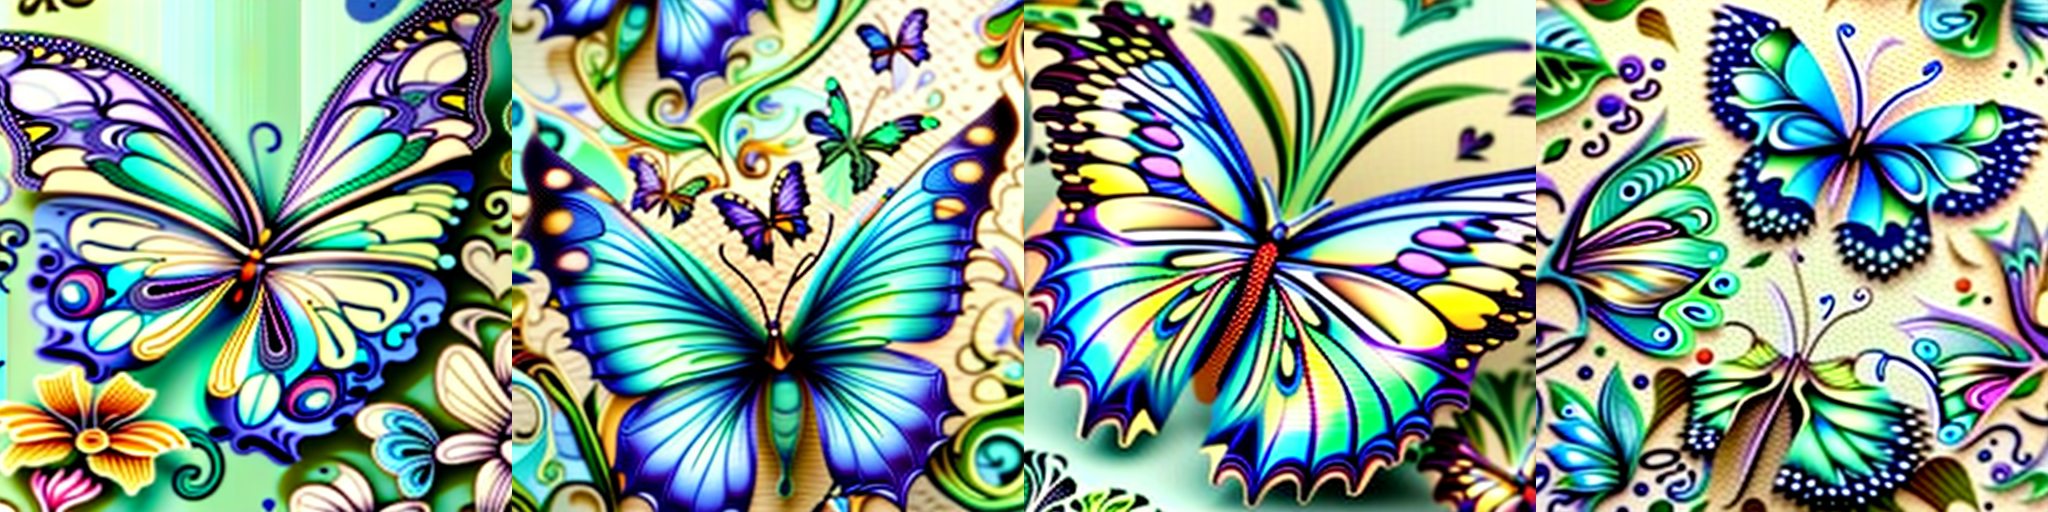

In [12]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

## Image-to-Image

In [ ]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

In [ ]:
# read image prompt
image = Image.open("assets/images/river.png")
g_image = Image.open("assets/images/vermeer.jpg")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

## Inpainting

In [ ]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

In [ ]:
# read image prompt
image = Image.open("assets/images/girl.png")
image.resize((256, 256))

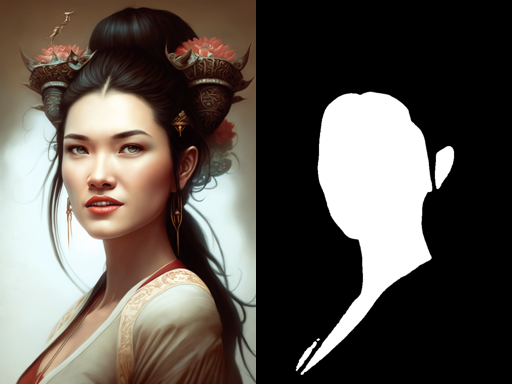

In [ ]:
masked_image = Image.open("assets/inpainting/image.png").resize((512, 768))
mask = Image.open("assets/inpainting/mask.png").resize((512, 768))
image_grid([masked_image.resize((256, 384)), mask.resize((256, 384))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/35 [00:00<?, ?it/s]

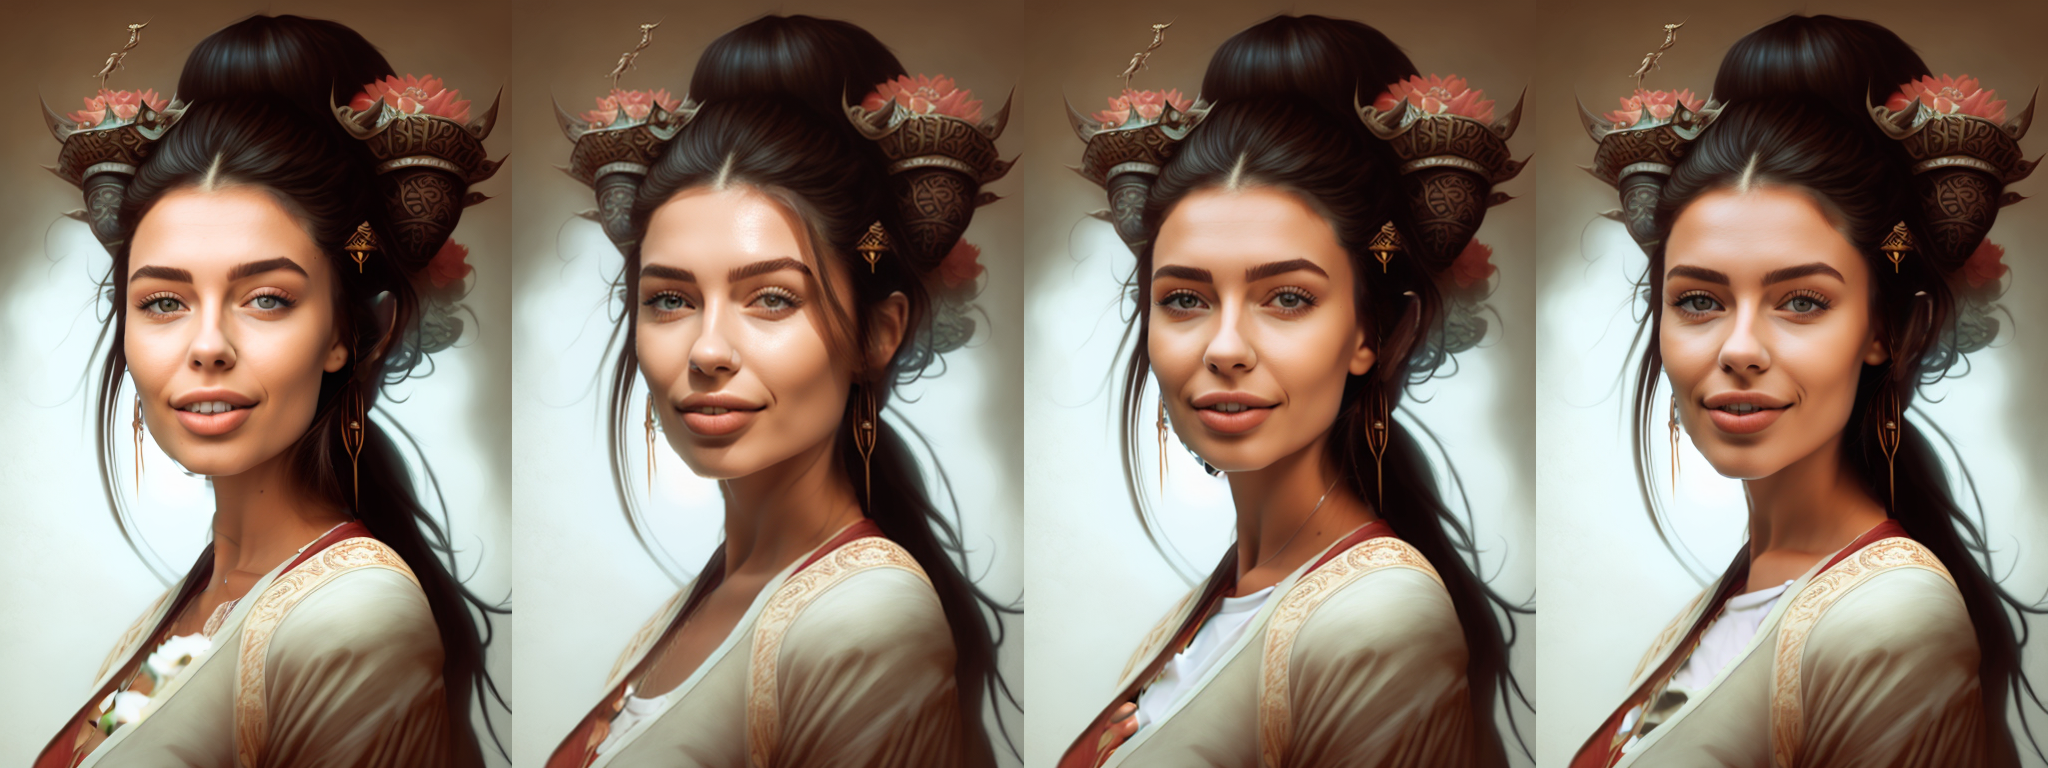

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, )
grid = image_grid(images, 1, 4)
grid